In [2]:
# imports

# for numerical analysis
import numpy as np
# to store and process data in dataframe
import pandas as pd

# basic visualization package
import matplotlib.pyplot as plt
# advanced plotting
import seaborn as sns


In [3]:
# load data

#datasources: 
# https://www.kaggle.com/mkkoehler/covid19-statistical-analysis-in-germany
# https://www.kaggle.com/headsortails/covid19-us-county-jhu-data-demographics


#covid data
path_covid_de = '.\data_ger\covid_de.csv' 
path_covid_us = '.\data_us\covid_us_county.csv'

#population Munich & LA Metro Area (wikipedia)
pop_muc = 5991144 
pop_la = 10039107

#getting the data
de_covid  = pd.read_csv(path_covid_de, index_col="date", parse_dates=True) #cases and deaths per state and age and sex
us_covid  = pd.read_csv(path_covid_us, index_col="date", parse_dates=True) #cases and deaths per state and age and sex



In [4]:
# view data
de_covid.head()

,state,county,age_group,gender,cases,deaths,recovered
date,,,,,,,
2020-03-27,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,1,0,1
2020-03-28,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,1,0,1
2020-04-03,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,1,0,1
2020-04-05,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,M,1,0,1
2020-05-18,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,M,1,0,1


In [5]:
us_covid.head()

,fips,county,state,lat,long,cases,state_code,deaths
date,,,,,,,,
2020-01-22,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
2020-01-23,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
2020-01-24,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
2020-01-25,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0
2020-01-26,1001.0,Autauga,Alabama,32.539527,-86.644082,0,AL,0


In [6]:
#filter german data for munich
muc = de_covid[de_covid.county.eq('LK Muenchen')]
muc = muc.groupby('date').sum()
muc.head()

,cases,deaths,recovered
date,,,
2020-02-04,1,0,1
2020-03-03,2,0,2
2020-03-05,2,0,2
2020-03-09,3,0,3
2020-03-10,6,0,6


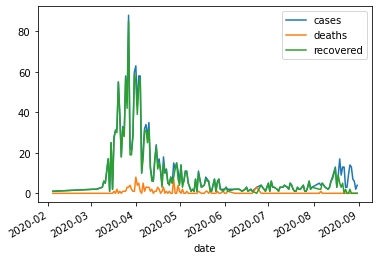

In [7]:
# view munich data
muc.plot()

In [8]:
# dismiss recovered because its obviously false
muc = muc.drop('recovered', axis=1)

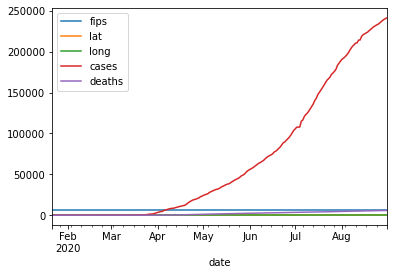

In [9]:
# filter for la

la = us_covid[us_covid.county.eq('Los Angeles')]
la = la.groupby('date').sum()

# view la data: 
la.plot()

In [10]:
# la data is cumulative: retrieve daily cases from cumulative cases

def get_daily_vals(cumulative_data):
    daily_data = []
    prev_value = 0
    for value in cumulative_data:
        daily_data.append(value-prev_value)
        prev_value = value  
    return daily_data

# write to new column
la['cases_daily'] = get_daily_vals(la['cases'])
la['deaths_daily'] = get_daily_vals(la['deaths'])

In [11]:
la['cases'].head(7), la['cases_daily'].head(7)

(date
 2020-01-22    0
 2020-01-23    0
 2020-01-24    0
 2020-01-25    0
 2020-01-26    1
 2020-01-27    1
 2020-01-28    1
 Name: cases, dtype: int64,
 date
 2020-01-22    0
 2020-01-23    0
 2020-01-24    0
 2020-01-25    0
 2020-01-26    1
 2020-01-27    0
 2020-01-28    0
 Name: cases_daily, dtype: int64)

In [12]:
# dismiss unused columns

la = la.drop(['fips', 'lat', 'long', 'cases', 'deaths'], axis=1)
la.head()

,cases_daily,deaths_daily
date,,
2020-01-22,0,0
2020-01-23,0,0
2020-01-24,0,0
2020-01-25,0,0
2020-01-26,1,0


In [13]:
# calculate rate per 100k population 

muc_rate = muc/pop_muc*100000
la_rate = la/pop_la*100000

#print(muc_rate.head(), la_rate.head())

In [14]:
#also display moving average

#define averaging window in days
avg_window = 7

# calculate X-day-moving-average
def moving_average (values, window, add_padding=False):
    weights = np.repeat(1.0, window)/window
    movavg = np.convolve(values, weights, 'same')
    return movavg

#print(len(moving_average(muc_rate['cases'].values, avg_window)), len(muc_rate['cases']))
muc_rate[str(avg_window) + '-day-avg'] = moving_average(muc_rate['cases'].values, avg_window)
la_rate[str(avg_window) + '-day-avg'] = moving_average(la_rate['cases_daily'].values, avg_window)
muc_rate[str(avg_window) + '-day-avg-death'] = moving_average(muc_rate['deaths'].values, avg_window)
la_rate[str(avg_window) + '-day-avg-death'] = moving_average(la_rate['deaths_daily'].values, avg_window)

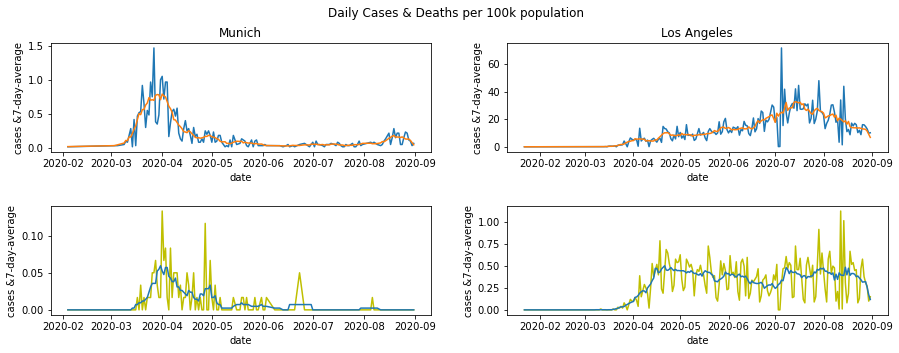

In [15]:
# visually compare muc to la: daily cases & deaths
fig, ax = plt.subplots(2, 2, figsize=(15, 5), sharex=False)

#plots
sns.lineplot(x=muc_rate.index, y='cases', data=muc_rate, legend='brief', ax=ax[0,0])
sns.lineplot(x=muc_rate.index, y= str(avg_window) + '-day-avg', data=muc_rate, ax=ax[0,0])

sns.lineplot(x=la_rate.index, y='cases_daily', data=la_rate, ax=ax[0,1])
sns.lineplot(x=la_rate.index, y= str(avg_window) + '-day-avg', data=la_rate, ax=ax[0,1])

sns.lineplot(x=muc_rate.index, y='deaths', data=muc_rate, color='y', ax=ax[1,0])
sns.lineplot(x=muc_rate.index, y= str(avg_window) + '-day-avg-death', data=muc_rate, ax=ax[1,0])

sns.lineplot(x=la_rate.index, y='deaths_daily', data=la_rate, color='y', ax=ax[1,1])
sns.lineplot(x=la_rate.index, y= str(avg_window) + '-day-avg-death', data=la_rate, ax=ax[1,1])

#styles
fig.suptitle('Daily Cases & Deaths per 100k population')
plt.subplots_adjust(hspace=0.5)
ax[0,0].set_title('Munich')
ax[0,1].set_title('Los Angeles')
ylabel = 'cases &' + str(avg_window) + '-day-average'
ax[0,0].set_ylabel(ylabel)
ax[0,1].set_ylabel(ylabel)
ax[1,0].set_ylabel(ylabel)
ax[1,1].set_ylabel(ylabel);